In [4]:
from darts.models import NBEATSModel, LightGBMModel
import import_ipynb
import ts_fc_functions as ff
import ts_fc_chronos_functions as cf
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


In [5]:
# Step 0: Load CSV files
# Reference your CSV files with CRP-values and administered antibiotics here
crp = pd.read_csv("./data/data_crp_new.csv",sep=';')
ab_administered = pd.read_csv("./data/ab_groups_no_cotrim_new.csv")
covariates = False

In [6]:
# Step 1: Data preprocessing
df_crp, df_ab_groups = ff.load_data_from_csv_and_merge_no_covars(crp,ab_administered)
data = ff.create_merge_no_covars(df_crp, df_ab_groups)
train_series_dict_full, train_series_covars_full,valid_series_dict_full,train_series_covars,resampled_df = ff.data_processing(data)


In [14]:
# Step 2: Load pretrained models

# Gradient Boosting - LightGBM models
lgbm_v1 = LightGBMModel.load("./models_prod/model_lgbm.pkl")
lgbm_v2 = LightGBMModel.load("./models_prod/best_model_lgbm_no_covars_proba.pkl")
# Deep Learning - NBeats models
nbeats_v1 = NBEATSModel.load("./models_prod/model_nbeats.pth.tar")
nbeats_v2 = NBEATSModel.load("./models_prod/best_model_nbeats_full.pth.tar")
# Weighted Ensemble of DL models - AutoGluonTS WeightedEnsemble
ensemble = TimeSeriesPredictor.load("./autogluon")
# Zero-shot large language model - Chronos


In [20]:
# Step 3: Perfrom CRP predictions and calculate metrics
# Set model type for which predictions should be performed
# [lgbm_v1,lgbm_v2,nbeats_v1,nbeats_v2,ensemble,chronos]
model = ensemble

if model in (lgbm_v1,lgbm_v2,nbeats_v1,nbeats_v2):
    predicted_values, actual_values, keys, pred,pred_ci_down,pred_ci_up = ff.predict_proba(model,train_series_dict_full,valid_series_dict_full,covariates,train_series_covars)
elif model == ensemble:
    predictions, train_data, test_data, merged_data = ff.autogluon_data(resampled_df,model)
elif model == 'chronos':
    forecasts = cf.chronos_predict(train_series_dict_full,train_series_dict_full)

MAE: 3.6776
MSE: 26.3927
RMSE: 5.1374
MAPE: 36.6469%
SMAPE: 30.7149%


150


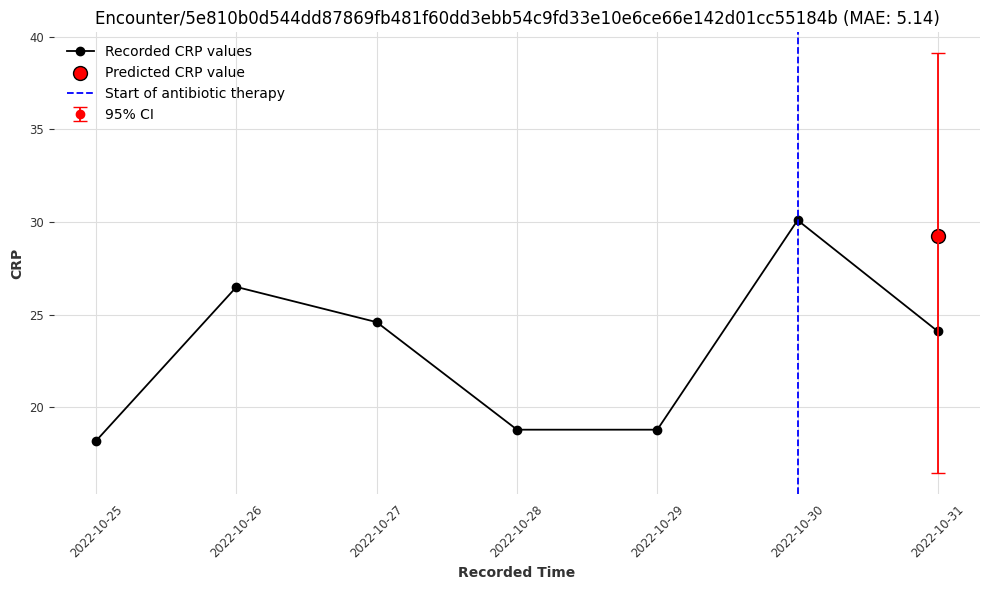

In [10]:
# Step 4: Visualize predictions
# Set an integer number for a fixed seed or None for a random seed
key_index = None

if model in (lgbm_v1,lgbm_v2,nbeats_v1,nbeats_v2):
    ff.plot_random_ts_proba(key_index, predicted_values, actual_values, keys, valid_series_dict_full, pred_ci_up, pred_ci_down)
elif model == ensemble:
    ff.plot_random_ts_proba_gluon(key_index,test_data, merged_data)
else:
    ff.plot_random_ts_proba(key_index, predicted_values, actual_values, keys, valid_series_dict_full, pred_ci_up, pred_ci_down)

In [12]:
forecasts

{'Encounter/001dd6b18e842c92e60667845203cf1aa40a2a8aa3c7218bcd38a17d43f35637': tensor([[[10.3005],
          [11.6934],
          [17.5585],
          [ 0.4032],
          [14.6992],
          [11.6934],
          [16.1288],
          [ 6.5982],
          [14.6992],
          [ 4.3988]]])}